In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

In [2]:
#stockdt = yf.download("^GSPC", start = "2000-01-01", end = "2023-06-01")
stockdt = yf.download("IBM", start = "2000-01-01", end = "2023-06-01")

[*********************100%***********************]  1 of 1 completed


In [3]:
stockdt['Close'][:6]

Date
2000-01-03    110.898659
2000-01-04    107.134323
2000-01-05    110.898659
2000-01-06    108.986618
2000-01-07    108.508606
2000-01-10    112.810707
Name: Close, dtype: float64

In [4]:
stockdt.shape

(5890, 6)

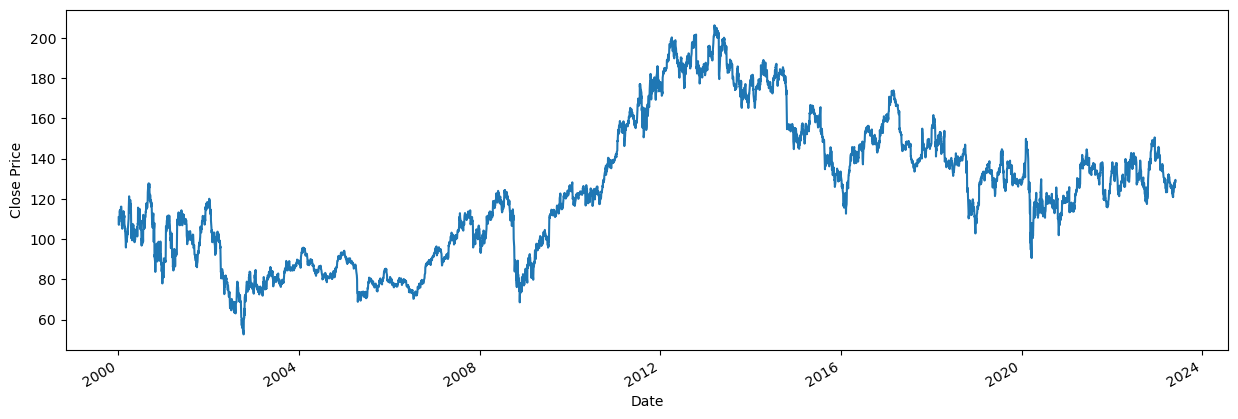

In [5]:
plt.figure(figsize=(15,5))
stockdt['Close'].plot()
plt.ylabel('Close Price')
plt.show()

# Smooth data

In [6]:
alpha = 0.045

In [7]:
stockdt['Smooth'] = pd.Series(np.array([0 for i in range(stockdt.shape[0])]))
stockdt['Smooth'][0] = stockdt['Close'][0]

/var/folders/l4/4c3v48694c9_55z0m5t2fwcc0000gn/T/ipykernel_77107/520032789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stockdt['Smooth'][0] = stockdt['Close'][0]


In [8]:
stockdt['Smooth']

Date
2000-01-03    110.898659
2000-01-04           NaN
2000-01-05           NaN
2000-01-06           NaN
2000-01-07           NaN
                 ...    
2023-05-24           NaN
2023-05-25           NaN
2023-05-26           NaN
2023-05-30           NaN
2023-05-31           NaN
Name: Smooth, Length: 5890, dtype: float64

In [9]:
for i in range(1, stockdt.shape[0]):
    stockdt['Smooth'][i] = alpha*stockdt['Close'][i-1] + (1-alpha)*stockdt['Smooth'][i-1]

/var/folders/l4/4c3v48694c9_55z0m5t2fwcc0000gn/T/ipykernel_77107/86259898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stockdt['Smooth'][i] = alpha*stockdt['Close'][i-1] + (1-alpha)*stockdt['Smooth'][i-1]


In [10]:
stockdt['Smooth'][:6]

Date
2000-01-03    110.898659
2000-01-04    110.898659
2000-01-05    110.729264
2000-01-06    110.736886
2000-01-07    110.658124
2000-01-10    110.561396
Name: Smooth, dtype: float64

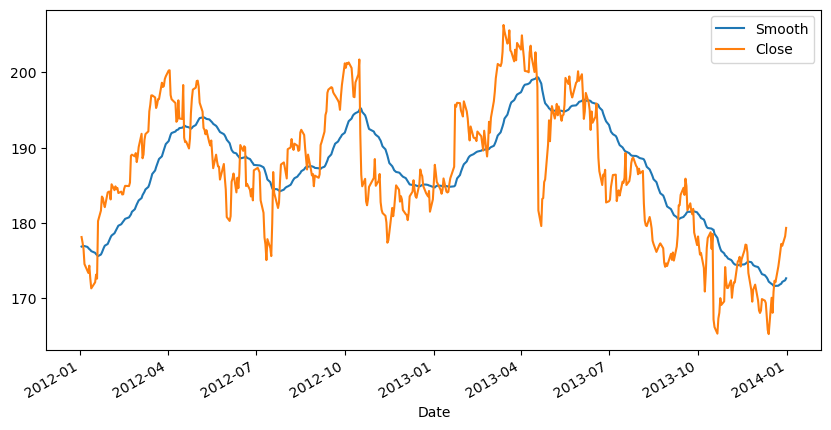

In [11]:
plt.figure(figsize=(10,5))
stockdt.loc["2012-01-01":"2014-01-01", ['Smooth']].plot(ax=plt.gca())
stockdt.loc["2012-01-01":"2014-01-01", ['Close']].plot(ax=plt.gca())
plt.show()

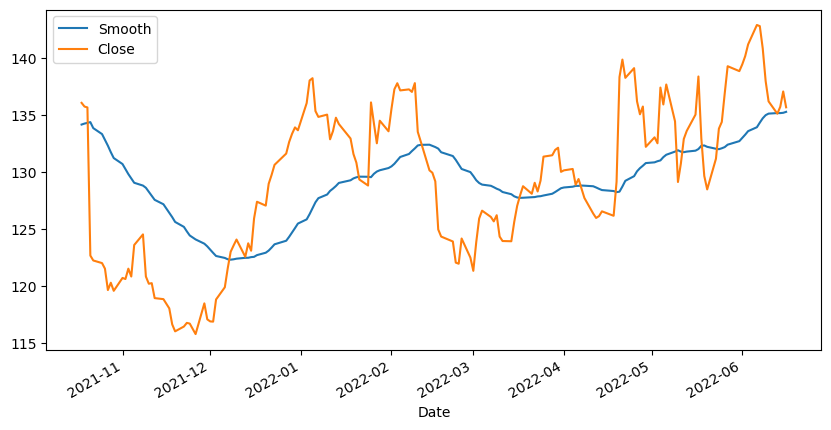

In [12]:
plt.figure(figsize=(10,5))
stockdt.loc["2021-10-16":"2022-06-16", ['Smooth']].plot(ax=plt.gca())
stockdt.loc["2021-10-16":"2022-06-16", ['Close']].plot(ax=plt.gca())
plt.show()

In [13]:
stockdt

,Open,High,Low,Close,Adj Close,Volume,Smooth
Date,,,,,,,
2000-01-03,107.492828,110.898659,106.955070,110.898659,62.428482,10823694,110.898659
2000-01-04,108.986618,109.464630,105.999046,107.134323,60.309441,8606279,110.898659
2000-01-05,107.970840,114.483749,107.194077,110.898659,62.428482,13318927,110.729264
2000-01-06,112.810707,113.706978,108.508606,108.986618,61.352131,8338607,110.736886
2000-01-07,112.093689,112.750954,105.760040,108.508606,61.083076,12402108,110.658124
...,...,...,...,...,...,...,...
2023-05-24,127.820000,127.900002,125.470001,125.680000,125.680000,3915500,126.525386
2023-05-25,125.610001,127.230003,125.010002,126.760002,126.760002,4102900,126.487344
2023-05-26,127.059998,129.660004,126.809998,128.889999,128.889999,5612600,126.499613


# Technical Indicators


RELATIVE STRENGTH INDEX (RSI)

It evaluates the conditions of overbought and oversold in the stock prices by measuring the extent of recent changes in prices. The RSI compares stock’s average gains and losses over a specific period of time, typically 14 trading days. RSI ranges between 0 and 100, and traditionally, RSI above 70 indicates that the stock is overbought, while RSI below 30 indicates that the stock is oversold.
In this paper, we use a 27-day time-frame to calculate the initial value of the RSI. The formula for calculating RSI is:


$RSI = 100 - \dfrac{100}{1+RS}$


$RS = \dfrac{Average gain over 27 days}{Average loss over 27 days}$

RSI stands for relative strength index, and RS stands for relative strength.


In [14]:
def RSI(series):
    delta = series.diff()
    up = delta.clip(lower = 0)
    down = -1.0*delta.clip(upper = 0)
    
    ema_up = up.ewm(com = 26, adjust = False).mean()
    ema_down = down.ewm(com = 26, adjust = False).mean()
    
    rs = ema_up / ema_down
    rsi = 100 - (100 / (1+rs))
    return rsi

In [15]:
stockdt['RSI'] = RSI(stockdt['Smooth'])

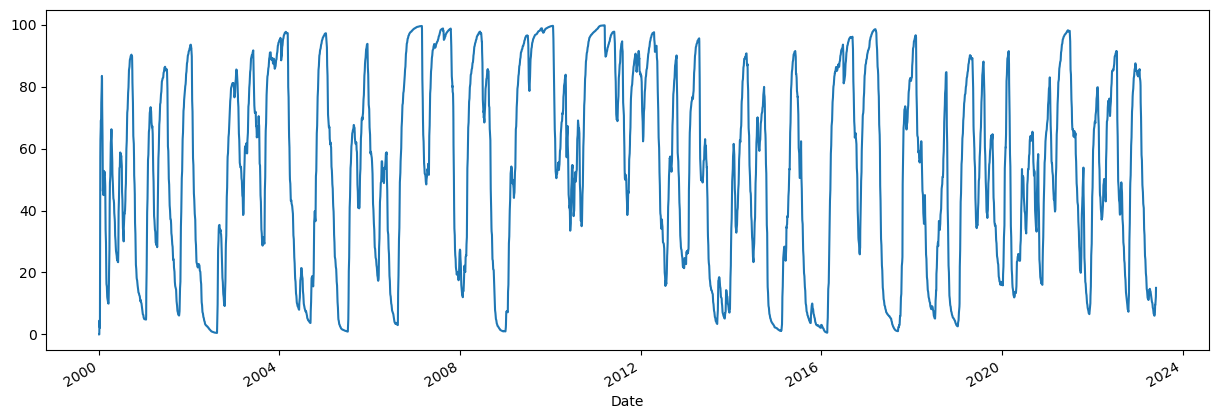

In [16]:
plt.figure(figsize=(15,5))
stockdt['RSI'].plot()
plt.show()

MOVING AVERAGE CONVERGENCE DIVERGENCE (MACD)

The moving average convergence divergence (MACD) is defined to be a trend-following momentum indicator that helps investors understand whether the bearish or bullish movement in prices is becoming stronger or weaker.

It is computed by subtracting the 26-day exponential moving average which is the longer moving average from the 12-day exponential moving average of a security’s prices which is defined to be the shorter one. The line obtained from this calculation called the MACD line and the 9-day exponential moving average of the MACD line called the signal line which can work as an incitement for buy and sell signals. However, MACD indicates a buy signal whenever it is above the signal line and a sell signal whenever it is below the signal line.

The formula for calculating MACD is as follows:


$MACD = EMA_{12}(C) - EMA_{26}(C)$

$SL = EMA_9(MACD)$

MACD stands for moving average convergence divergence or MACD line and SL stands for the signal line.

$EMA_n$= n-day exponential moving average

C = closing price

In [17]:
def MACD(series):
    ema_12 = series.ewm(span = 12).mean()
    ema_26 = series.ewm(span = 26).mean()
    macd = ema_12 - ema_26
    signal = macd.ewm(span = 9).mean()
    return macd, signal

In [18]:
stockdt['MACD'] = MACD(stockdt['Smooth'])[0] - MACD(stockdt['Smooth'])[1]

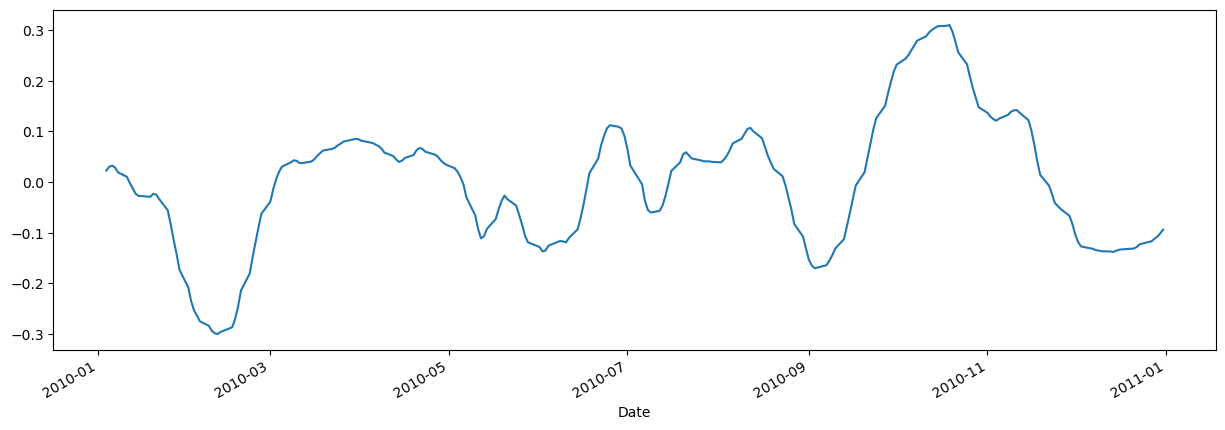

In [19]:
plt.figure(figsize=(15,5))
stockdt.loc['2010-01-01':'2011-01-01', 'MACD'].plot(ax=plt.gca())
plt.show()

PRICE RATE OF CHANGE (ROC)

The price rate of change (ROC) is another momentum oscillator that compares and cal- culates the percent change in price between the current price and the price n-periods ago. In other words, ROC measures the changes between the current price with respect to the earlier closing price in n days ago. It moves from positive to negative, and fluctu- ates above and below the zero-line. However, this oscillator can be used for determining the overbought and oversold conditions, divergences and also zero-line crossovers.
We use a 21-day time-frame to calculate the initial value of the ROC. The formula for calculating ROC is as follows:

$ROC = \dfrac{C_t - C_{t-21}}{C_{t-21}} .100$

where,

ROC stands for price rate of change at time t; 

Ct = closing price at time t;

Ct−21 = closing price 21 periods ago

In [20]:
def ROC(series):
    return (series - series.shift(21))*100/series.shift(21)

In [21]:
stockdt['ROC'] = ROC(stockdt['Smooth'])

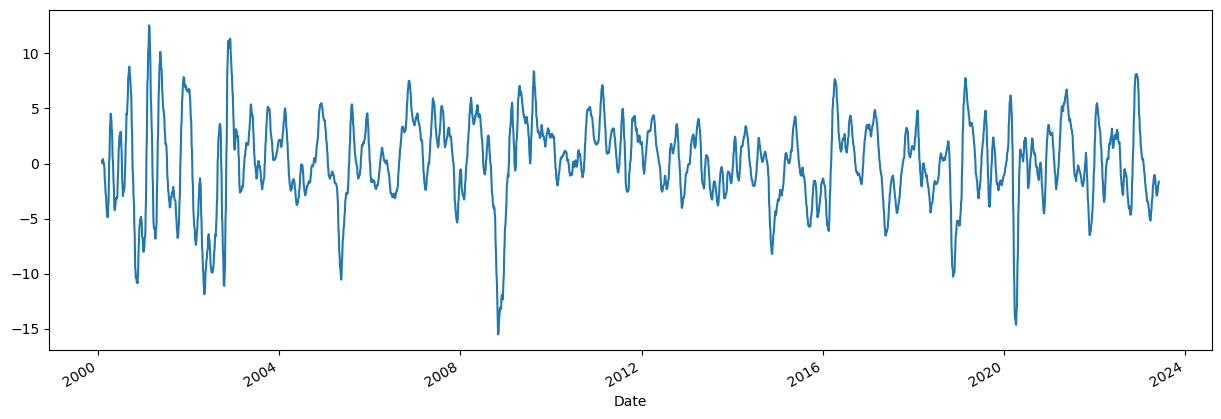

In [22]:
plt.figure(figsize=(15,5))
stockdt['ROC'].plot()
plt.show()

STOCHASTIC OSCILLATOR (%K)

The stochastic oscillator which is often denoted by the symbol (%K), is a momentum oscillator that was developed by George Lane. The stochastic oscillator identifies the location of the stock’s closing price relative to the high and low range of the stock’s price over a period of time, typically being 14 trading days. The stochastic oscillator varies from 0 to 100, a reading above 80 generally represents overbought while below 20 represents oversold. We use a 14-day time-frame %K. The formula for calculating the stochastic oscillator is given below:

$\% K = \dfrac{C_t - L_{14}}{H_{14} - L_{14}} \times 100$

where,

Ct = the current closing price.

L14 = lowest low over the past 14 days H14 = highest high in the last 14 days

In [23]:
def STO_OS(low, high, smooth):
    low_14 = low.rolling(14).min()
    high_14 = high.rolling(14).max()
    return (smooth - low_14)*100/(high_14 - low_14)

In [24]:
stockdt['%K'] = STO_OS(stockdt['Low'], stockdt['High'], stockdt['Smooth'])

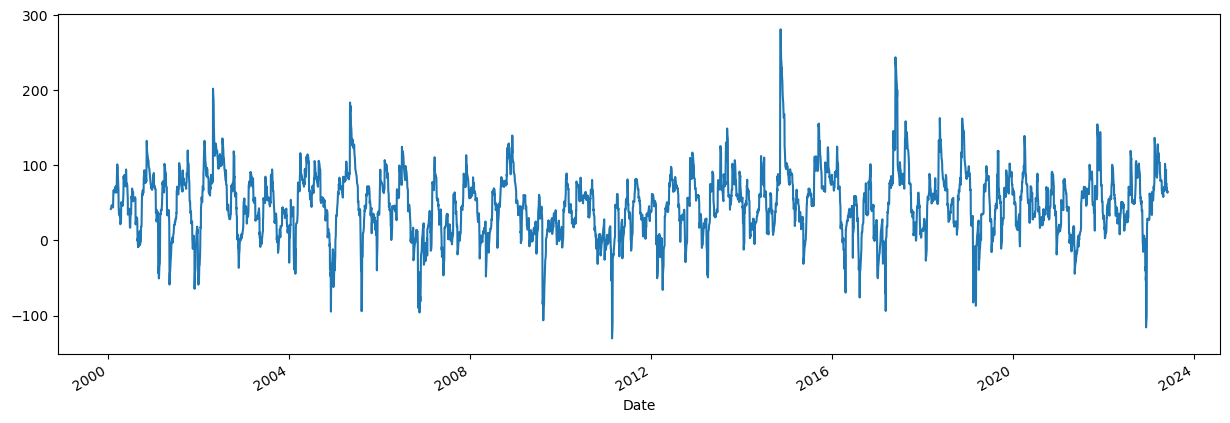

In [25]:
plt.figure(figsize=(15,5))
stockdt['%K'].plot()
plt.show()

WILLIAMS PERCENTAGE RANGE (WILLIAM %R)

Williams percentage range which is also called Williams %R is a common indicator developed by Larry Williams. This indicator is often denoted by the symbol (%R), it measures the overbought and oversold levels and it works inversely to %K. Whilst %K ranges between 0 and 100, %R ranges between 0 and -100. A Williams %R below -80 indicates a buy signal, whereas a Williams %R above -20 indicates a sell signal.
We use also a 14-day time frame %R, the formula used to calculate the Williams %R is:

$\% R = \dfrac{H_{14} - C_t}{H_{14} - L_{14}} \times -100$

where,

Ct = the current closing price

L14 = lowest low over the past 14 days H14 = highest high in the last 14 days


In [26]:
def WILLIAM(low, high, smooth):
    low_14 = low.rolling(14).min()
    high_14 = high.rolling(14).max()
    return (high_14 - smooth)*-100/(high_14 - low_14)

In [27]:
stockdt['%R'] = WILLIAM(stockdt['Low'], stockdt['High'], stockdt['Smooth'])

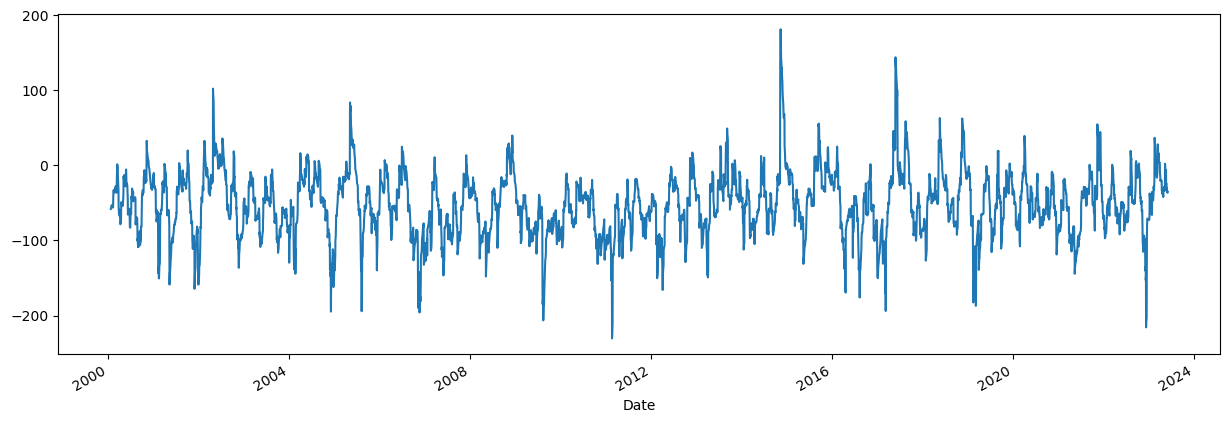

In [28]:
plt.figure(figsize=(15,5))
stockdt['%R'].plot()
plt.show()

COMMODITY CHANNEL INDEX (CCI)

The Commodity Channel Index (CCI) was developed by Donald Lambert, it is a useful oscillator that is used to estimate the direction and the strength of the stock price trend. This indicator is also used to determine when stock prices reach the condition of either overbought and oversold. The CCI is calculated by first determining the difference between the mean price of a stock and the average of the means, then comparing this difference to the average difference over a period of time, typically 20 days. The CCI is often scaled by an inverse factor of 0.015. The formula used to calculate the CCI is:

$CCI = \dfrac{TypicalPrice - MA_{20}}{0.015 \times D}$

where,
Typical price = average of low, high and close prices: $\sum_{i = 1}^{20}(H+L+C)/3$
    
MA20 = simple moving average over 20 days 

D = mean deviation

In [29]:
def CCI(high, low, smooth):
    typical_price = (high + low + smooth) / 3
    rolling_mean = typical_price.rolling(window=20).mean()
    rolling_std = typical_price.rolling(window=20).std()
    return (typical_price - rolling_mean) / (0.015 * rolling_std)


In [30]:
stockdt['CCI'] = CCI(stockdt['High'], stockdt['Low'], stockdt['Smooth'])

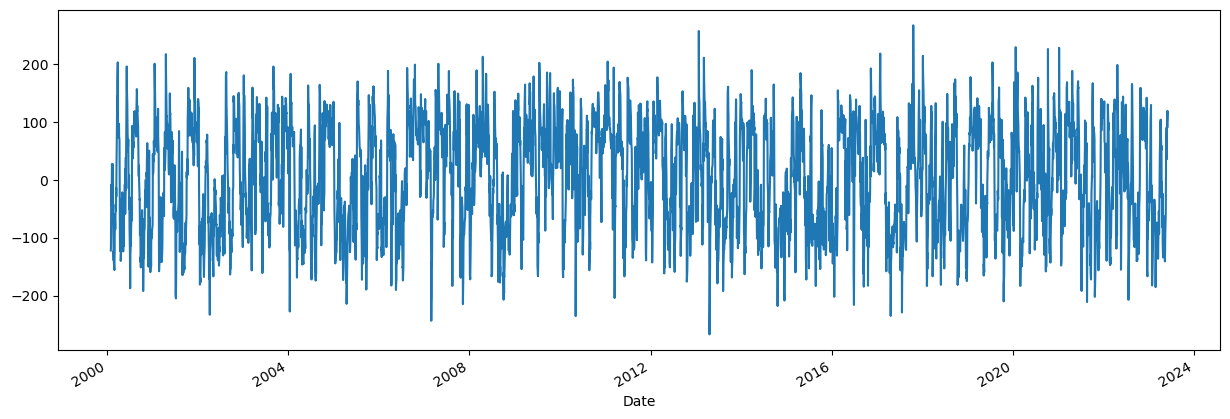

In [31]:
plt.figure(figsize=(15,5))
stockdt['CCI'].plot()
plt.show()

DISPARITY INDEX (DIX)

The Disparity Index (DIX) is another useful indicator that is used commonly in technical analysis. This indicator was developed by Steve Nison and it is a momentum indicator that compares the stock’s current price with its moving average (MA) over a particular time period. DIX below 0 indicates that the stock’s current price is below the n-day MA, DIX above 0 indicates that the stock’s current price is above the n-day MA, whereas in the case the DIX equals 0 indicates that the stock’s current price is equal to the n-day MA. 14-day MA is used in this paper. The formula for calculating the DIX with 14-day MA is as follows:


$DIX = \dfrac{C_t - MA_{14}}{MA_{14} \times 100}$

where,

Ct = current stock price.

MA14 = moving average over 14 days

In [32]:
def DIX(smooth):
    ma_14 = smooth.rolling(window=14).mean()
    return (smooth - ma_14)/(ma_14)

In [33]:
stockdt['DIX'] = DIX(stockdt['Smooth'])

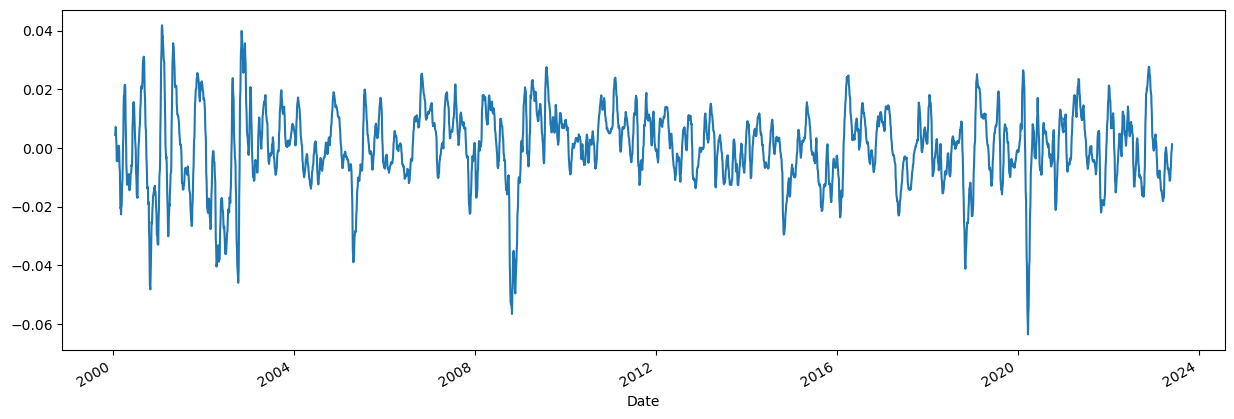

In [34]:
plt.figure(figsize=(15,5))
stockdt['DIX'].plot()
plt.show()

# DATA LABELLING

In [35]:
stockdt['Target_30_smooth'] = np.sign(stockdt['Smooth'].shift(-30) - stockdt['Smooth'])

In [36]:
stockdt.dropna(axis=0, inplace = True)

In [37]:
stockdt[100:150]

,Open,High,Low,Close,Adj Close,Volume,Smooth,RSI,MACD,ROC,%K,%R,CCI,DIX,Target_30_smooth
Date,,,,,,,,,,,,,,,
2000-06-26,108.030594,110.659653,107.911087,109.375000,61.709957,3792691,107.809524,57.794177,0.282812,2.500286,17.010972,-82.989028,7.789749,0.008629,-1.0
2000-06-27,106.716064,107.851341,103.967499,104.923515,59.198380,6911863,107.879970,58.384508,0.245966,2.715065,30.174721,-69.825279,-50.479750,0.007298,-1.0
2000-06-28,105.162521,110.121895,105.043022,108.777489,61.372814,6732684,107.746930,56.825733,0.199673,2.711336,32.944042,-67.055958,-29.415457,0.004488,-1.0
2000-06-29,106.835564,109.345123,105.222275,108.986618,61.490810,8042171,107.793305,57.238995,0.160878,2.704608,33.522883,-66.477117,-46.148256,0.003598,-1.0
2000-06-30,107.731834,108.209846,103.847992,104.744263,59.097282,9008780,107.847004,57.725571,0.128919,2.859918,34.677440,-65.322560,-84.570725,0.003001,-1.0
2000-07-03,103.967499,105.043022,103.549232,104.684509,59.063564,2410402,107.707381,56.004852,0.090288,2.881738,35.146842,-64.853158,-123.400228,0.000923,1.0
2000-07-05,100.979927,100.979927,96.677818,100.382408,56.636276,14999222,107.571351,54.365290,0.049524,2.781105,58.247330,-41.752670,-187.081957,-0.000803,1.0
2000-07-06,100.382408,100.501915,95.602295,96.797325,54.613598,13527604,107.247849,50.699703,-0.002515,2.331621,58.882172,-41.117828,-159.529107,-0.003934,1.0
2000-07-07,98.171608,100.442162,97.155830,100.442162,56.669971,9447158,106.777575,46.015954,-0.068256,1.768033,56.504378,-43.495622,-129.381401,-0.007982,1.0


# CORRELATION AMONG FEATURES AND TARGET

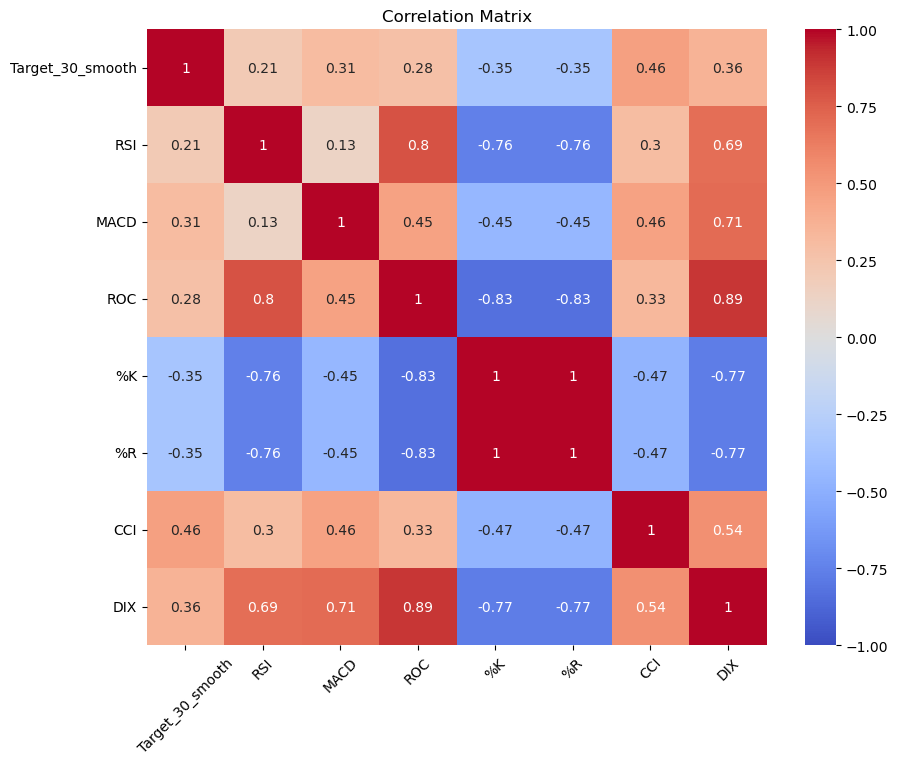

In [38]:
# Calculate the correlation matrix
correlation_matrix = stockdt[['Target_30_smooth', 'RSI', 'MACD', 'ROC', '%K', '%R', 'CCI', 'DIX']].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [39]:
stockdt = stockdt.drop('ROC', axis = 1)

In [40]:
stockdt = stockdt.drop('%K', axis = 1)

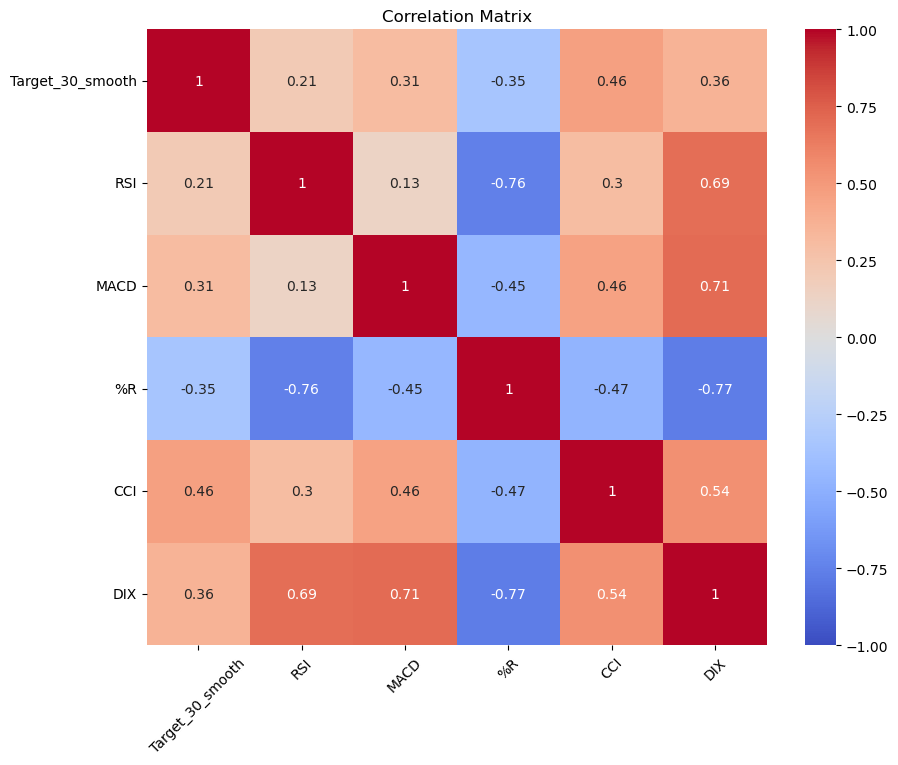

In [41]:
# Calculate the correlation matrix
correlation_matrix_ = stockdt[['Target_30_smooth', 'RSI', 'MACD', '%R', 'CCI', 'DIX']].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [42]:
stockdt.loc[:, 'RSI':]

,RSI,MACD,%R,CCI,DIX,Target_30_smooth
Date,,,,,,
2000-02-02,49.029173,-0.027997,-54.872445,-80.628123,-0.003351,-1.0
2000-02-03,46.258318,-0.054984,-55.643185,-25.931279,-0.004380,-1.0
2000-02-04,47.489604,-0.067266,-55.335241,-8.464913,-0.003933,-1.0
2000-02-07,46.988912,-0.073292,-55.473155,-43.971781,-0.003976,-1.0
2000-02-08,44.976159,-0.078531,-56.036863,9.347119,-0.004551,-1.0
...,...,...,...,...,...,...
2023-04-12,14.676567,0.260151,-19.996326,29.978292,0.000187,-1.0
2023-04-13,14.414189,0.266281,-21.528353,-30.401319,-0.000167,-1.0
2023-04-14,14.083592,0.262468,-33.470459,-3.196005,-0.000838,-1.0


# TRAIN TEST SPLIT CASE PREDICTING

In [43]:
X = stockdt.loc[:, 'RSI':'DIX']
y = stockdt.loc[:, 'Target_30_smooth']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

PROPORTION OF UP AND DOWN DAYS IN TRAINING SET

In [44]:
value_counts = pd.Series(y_train).value_counts()

# Get proportion of 1s and -1s
proportion_1 = value_counts.get(1, 0) / len(y_train)
proportion_minus_1 = value_counts.get(-1, 0) / len(y_train)

print("Proportion of 1s:", proportion_1)
print("Proportion of -1s:", proportion_minus_1)

Proportion of 1s: 0.5313637336758724
Proportion of -1s: 0.4686362663241276


PROPORTION OF UP AND DOWN DAYS IN TESTING SET

In [45]:
value_counts = pd.Series(y_test).value_counts()

# Get proportion of 1s and -1s
proportion_1 = value_counts.get(1, 0) / len(y_test)
proportion_minus_1 = value_counts.get(-1, 0) / len(y_test)

print("Proportion of 1s:", proportion_1)
print("Proportion of -1s:", proportion_minus_1)

Proportion of 1s: 0.5428082191780822
Proportion of -1s: 0.4571917808219178


In [46]:
grid_rf = {
'n_estimators': [75, 100, 150, 200],  
'max_depth': [2, 5, 7, 9, None],  
'max_features': [2, 3, 4]
}

cv = KFold(n_splits=4, shuffle=False)
gscv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_rf, cv=cv, scoring='accuracy')
gscv_fit = gscv.fit(X_train, y_train)
best_parameters = gscv_fit.best_params_
print("Hyperparameter: ", best_parameters)

model = RandomForestClassifier(**best_parameters, random_state = 42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Hyperparameter:  {'max_depth': None, 'max_features': 3, 'n_estimators': 100}


In [47]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
confusion_mat = confusion_matrix(y_test, y_pred)

In [48]:
print("TARGET 30 DAYS")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_mat)

TARGET 30 DAYS
Accuracy: 0.8116438356164384
Precision: 0.8106837606837607
Recall: 0.8092191542905753
F1 Score: 0.809832241487003
Confusion Matrix:
[[417 117]
 [103 531]]


# 2 UNSHUFFLED TRAINING SET AND TEST SET CASE

In [49]:
# ^GSPC AAPL IBM
x_train = stockdt.loc['2000-01-01':'2019-05-31', 'RSI':'DIX']
y_train = stockdt.loc['2000-01-01':'2019-05-31', 'Target_30_smooth']

PROPORTION OF UP AND DOWN DAYS IN TRAINING SET

In [50]:
value_counts = y_train.value_counts()

# Get proportion of 1s and -1s
proportion_1 = value_counts.get(1, 0) / len(y_train)
proportion_minus_1 = value_counts.get(-1, 0) / len(y_train)

print("Proportion of 1s:", proportion_1)
print("Proportion of -1s:", proportion_minus_1)

Proportion of 1s: 0.5477169888934594
Proportion of -1s: 0.4522830111065405


In [51]:
x_train

,RSI,MACD,%R,CCI,DIX
Date,,,,,
2000-02-02,49.029173,-0.027997,-54.872445,-80.628123,-0.003351
2000-02-03,46.258318,-0.054984,-55.643185,-25.931279,-0.004380
2000-02-04,47.489604,-0.067266,-55.335241,-8.464913,-0.003933
2000-02-07,46.988912,-0.073292,-55.473155,-43.971781,-0.003976
2000-02-08,44.976159,-0.078531,-56.036863,9.347119,-0.004551
...,...,...,...,...,...
2019-05-24,56.746371,-0.295735,-21.930347,-83.728814,-0.007411
2019-05-28,53.865931,-0.291574,-16.784474,-103.276347,-0.007929
2019-05-29,50.405807,-0.293875,-0.938804,-128.510214,-0.008852


In [52]:
grid_rf = {
'n_estimators': [75, 100, 150, 200],  
'max_depth': [2, 5, 7, 9, None],  
'max_features': [2, 3, 4]
}

cv = KFold(n_splits=4, shuffle=False)
gscv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_rf, cv=cv, scoring='accuracy')
gscv_fit = gscv.fit(x_train, y_train)
best_parameters = gscv_fit.best_params_
print("Hyperparameter: ", best_parameters)

model = RandomForestClassifier(**best_parameters, random_state = 42)
model.fit(x_train, y_train)

Hyperparameter:  {'max_depth': 2, 'max_features': 3, 'n_estimators': 150}


RandomForestClassifier(max_depth=2, max_features=3, n_estimators=150,
                       random_state=42)

# MODEL TESTING FROM 2019-06-01 TO 2023-06-01

In [53]:
y_pred = model.predict(stockdt.loc['2019-06-01':, 'RSI':'DIX'].values)
y_test = stockdt.loc['2019-06-01':, 'Target_30_smooth'].values

/Users/nguyenthanhbinh/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


PROPORTION OF UP AND DOWN DAYS IN TESTING SET

In [54]:
value_counts = pd.Series(y_test).value_counts()

# Get proportion of 1s and -1s
proportion_1 = value_counts.get(1, 0) / len(y_test)
proportion_minus_1 = value_counts.get(-1, 0) / len(y_test)

print("Proportion of 1s:", proportion_1)
print("Proportion of -1s:", proportion_minus_1)

Proportion of 1s: 0.46366427840327534
Proportion of -1s: 0.5363357215967247


In [55]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
confusion_mat = confusion_matrix(y_test, y_pred)

In [56]:
print("TARGET 30 DAYS FROM 2019-06-01 TO 2023-06-01")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_mat)

TARGET 30 DAYS FROM 2019-06-01 TO 2023-06-01
Accuracy: 0.6438075742067554
Precision: 0.6459971768501714
Recall: 0.6464031140993883
F1 Score: 0.6437624160736289
Confusion Matrix:
[[320 204]
 [144 309]]


# K-FOLDS CROSS-VALIDATION

In [57]:
X = stockdt.loc[:, 'RSI':'DIX'].values
y = stockdt.loc[:, 'Target_30_smooth'].values

In [58]:
folds = 5

In [59]:
kfold = KFold(n_splits=folds, shuffle=False)
models = []
scores = []

In [60]:
for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    value_counts_train = pd.Series(y_train).value_counts()

    # Get proportion of 1s and -1s in training set
    proportion_1_train = value_counts_train.get(1, 0) / len(y_train)
    proportion_minus_1_train = value_counts_train.get(-1, 0) / len(y_train)

    print("Proportion of 1s of Target_30_smooth in training set:", proportion_1_train)
    print("Proportion of -1s of Target_30_smooth in training set:", proportion_minus_1_train)
    
    value_counts_test = pd.Series(y_test).value_counts()

    # Get proportion of 1s and -1s in testing set
    proportion_1_test = value_counts_test.get(1, 0) / len(y_test)
    proportion_minus_1_test = value_counts_test.get(-1, 0) / len(y_test)

    print("Proportion of 1s of Target_30_smooth in testing set:", proportion_1_test)
    print("Proportion of -1s of Target_30_smooth in testing set:", proportion_minus_1_test)
    
    grid_rf = {
    'n_estimators': [75, 100, 150, 200],  
    'max_depth': [2, 5, 7, 9, None],  
    'max_features': [2, 3, 4]
    }
    
    cv = KFold(n_splits=4, shuffle=False)
    gscv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_rf, cv=cv, scoring='accuracy')
    gscv_fit = gscv.fit(X_train, y_train)
    best_parameters = gscv_fit.best_params_
    print("Hyperparameter: ", best_parameters)
    
    model = RandomForestClassifier(**best_parameters, random_state = 42)
    model.fit(X_train, y_train)
    
    models.append(model)
    
    training_error = 1 - accuracy_score(y_train, model.predict(X_train))
    print("Training error:", training_error)
    
    y_pred = model.predict(X_test)
    
    score = model.score(X_test, y_test)
    scores.append(score)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    confusion_mat = confusion_matrix(y_test, y_pred)
    
    print("TARGET 30 DAYS")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:")
    print(confusion_mat)
    

Proportion of 1s of Target_30_smooth in training set: 0.5510597302504817
Proportion of -1s of Target_30_smooth in training set: 0.4489402697495183
Proportion of 1s of Target_30_smooth in testing set: 0.464041095890411
Proportion of -1s of Target_30_smooth in testing set: 0.535958904109589
Hyperparameter:  {'max_depth': 2, 'max_features': 4, 'n_estimators': 150}
Training error: 0.2727467351744809
TARGET 30 DAYS
Accuracy: 0.675513698630137
Precision: 0.6739336506843064
Recall: 0.6741361423198897
F1 Score: 0.6740224288522021
Confusion Matrix:
[[434 192]
 [187 355]]
Proportion of 1s of Target_30_smooth in training set: 0.5170199100834939
Proportion of -1s of Target_30_smooth in training set: 0.4829800899165061
Proportion of 1s of Target_30_smooth in testing set: 0.6001712328767124
Proportion of -1s of Target_30_smooth in testing set: 0.3998287671232877
Hyperparameter:  {'max_depth': 2, 'max_features': 4, 'n_estimators': 75}
Training error: 0.2905159494754871
TARGET 30 DAYS
Accuracy: 0.7602

# FEATURE IMPORTANCE IN K-FOLDS CROSS-VALIDATION

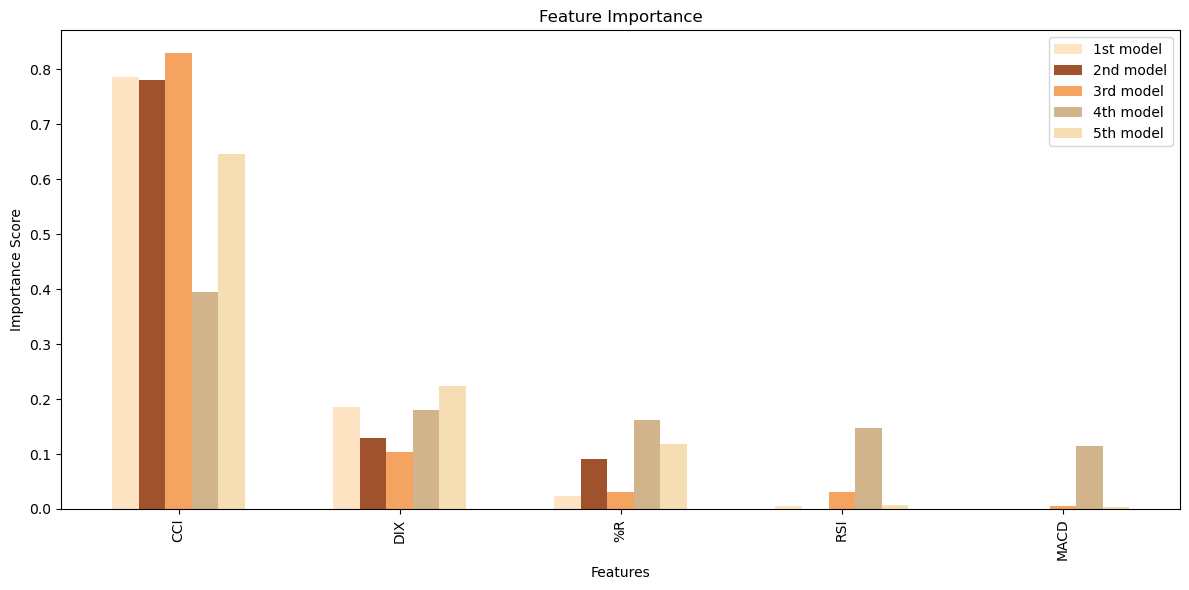

In [61]:
model_names = ['1st model', '2nd model', '3rd model', '4th model', '5th model']

feature_importances = []
for model in models:
    importance = model.feature_importances_
    feature_importances.append(importance)

num_features = len(x_train.columns)
bar_width = 0.12
index = np.arange(num_features)
colors = ['bisque', 'sienna', 'sandybrown', 'tan', 'wheat']  # Lighter shades of blue, green, and red

# Plotting the feature importance
plt.figure(figsize=(12, 6))

for i, feature_importance in enumerate(feature_importances):
    sorted_indices = feature_importance.argsort()[::-1]
    sorted_importance = feature_importance[sorted_indices]
    sorted_features = x_train.columns[sorted_indices]
    
    plt.bar(index + i * bar_width, sorted_importance, bar_width, align='center', color=colors[i], label=model_names[i])

plt.xticks(index+bar_width*2, sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance')
plt.legend()
plt.tight_layout()
plt.show()


# ROLLING CROSS-VALIDATION

In [62]:
folds = 5

In [63]:
tscv = TimeSeriesSplit(n_splits=folds)
models_ts = []
score_ts = []
train_ts = []

In [64]:
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print(len(X_train))
    
    value_counts_train = pd.Series(y_train).value_counts()

    # Get proportion of 1s and -1s in training set
    proportion_1_train = value_counts_train.get(1, 0) / len(y_train)
    proportion_minus_1_train = value_counts_train.get(-1, 0) / len(y_train)

    print("Proportion of 1s of Target_30_smooth in training set:", proportion_1_train)
    print("Proportion of -1s of Target_30_smooth in training set:", proportion_minus_1_train)
    
    value_counts_test = pd.Series(y_test).value_counts()

    # Get proportion of 1s and -1s in testing set
    proportion_1_test = value_counts_test.get(1, 0) / len(y_test)
    proportion_minus_1_test = value_counts_test.get(-1, 0) / len(y_test)

    print("Proportion of 1s of Target_30_smooth in testing set:", proportion_1_test)
    print("Proportion of -1s of Target_30_smooth in testing set:", proportion_minus_1_test)
    
    
    grid_rf = {
    'n_estimators': [75, 100, 150, 200],  
    'max_depth': [2, 5, 7, 9, None],  
    'max_features': [2, 3, 4]
    }
    
    cv = KFold(n_splits=4, shuffle=False)
    gscv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_rf, cv=cv, scoring='accuracy')
    gscv_fit = gscv.fit(X_train, y_train)
    best_parameters = gscv_fit.best_params_
    print("Hyperparameter: ", best_parameters)
    
    model = RandomForestClassifier(**best_parameters, random_state = 42)
    model.fit(X_train, y_train)
    
    models.append(model)
    
    training_error = 1 - accuracy_score(y_train, model.predict(X_train))
    print("Training error:", training_error)
    
    models_ts.append(model)
    
    training_error = 1 - accuracy_score(y_train, model.predict(X_train))
    train_ts.append(training_error)
    print("Training error:", training_error)
    
    y_pred = model.predict(X_test)
    
    score = model.score(X_test, y_test)
    score_ts.append(score)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    confusion_mat = confusion_matrix(y_test, y_pred)
    
    print("TARGET 30 DAYS")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:")
    print(confusion_mat)
    

974
Proportion of 1s of Target_30_smooth in training set: 0.49794661190965095
Proportion of -1s of Target_30_smooth in training set: 0.502053388090349
Proportion of 1s of Target_30_smooth in testing set: 0.539568345323741
Proportion of -1s of Target_30_smooth in testing set: 0.460431654676259
Hyperparameter:  {'max_depth': 2, 'max_features': 4, 'n_estimators': 150}
Training error: 0.2926078028747433
Training error: 0.2926078028747433
TARGET 30 DAYS
Accuracy: 0.6300102774922919
Precision: 0.6924053744060298
Recall: 0.6497767857142858
F1 Score: 0.6148568412719355
Confusion Matrix:
[[403  45]
 [315 210]]
1947
Proportion of 1s of Target_30_smooth in training set: 0.5187467899332306
Proportion of -1s of Target_30_smooth in training set: 0.4812532100667694
Proportion of 1s of Target_30_smooth in testing set: 0.7266187050359713
Proportion of -1s of Target_30_smooth in testing set: 0.2733812949640288
Hyperparameter:  {'max_depth': 2, 'max_features': 3, 'n_estimators': 100}
Training error: 0.27

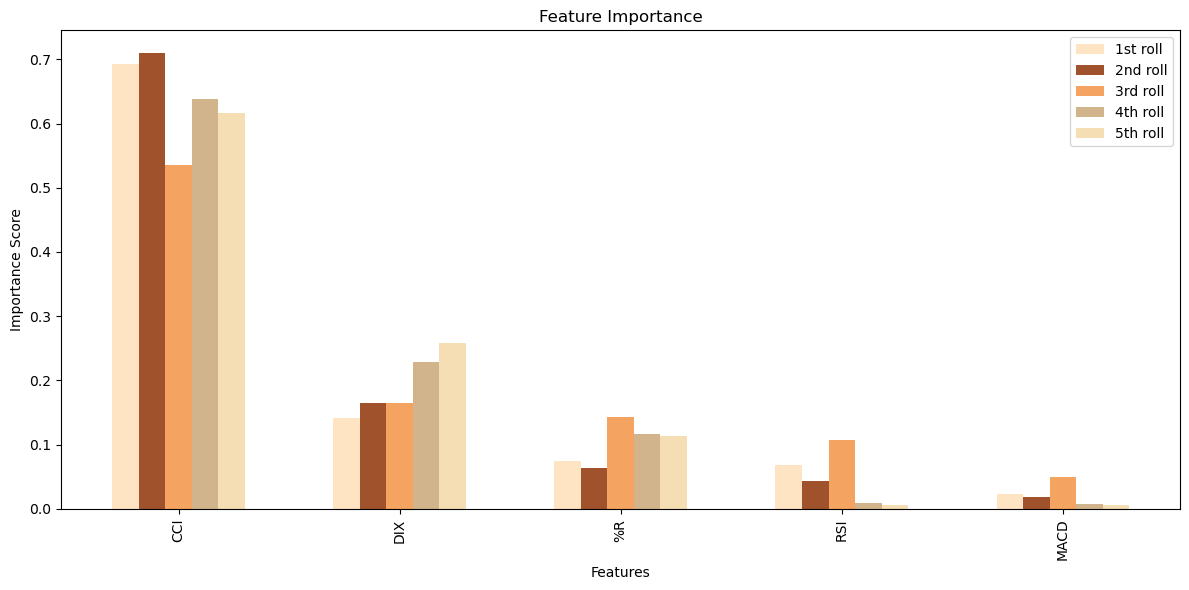

In [65]:
model_names = ['1st roll', '2nd roll', '3rd roll', '4th roll', '5th roll']

feature_importances = []
for model in models_ts:
    importance = model.feature_importances_
    feature_importances.append(importance)

num_features = len(x_train.columns)
bar_width = 0.12
index = np.arange(num_features)
colors = ['bisque', 'sienna', 'sandybrown', 'tan', 'wheat']  # Lighter shades of blue, green, and red

# Plotting the feature importance
plt.figure(figsize=(12, 6))

for i, feature_importance in enumerate(feature_importances):
    sorted_indices = feature_importance.argsort()[::-1]
    sorted_importance = feature_importance[sorted_indices]
    sorted_features = x_train.columns[sorted_indices]
    
    plt.bar(index + i * bar_width, sorted_importance, bar_width, align='center', color=colors[i], label=model_names[i])

plt.xticks(index+bar_width*2, sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance')
plt.legend()
plt.tight_layout()
plt.show()
